<a href="https://colab.research.google.com/github/patohdzs/getting-them-stonks/blob/main/stonks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Them Stonks: A (brief) Introduction to Portfolio Optimization
### Patricio Hernandez Senosiain 
---

## Motivation

#### **Scenario:** You won the lottery, recieved the paycheck for your summer internship, or that distant uncle you didn't even know passed and left you some money... what do you do?
#### **A:** Invest... but how?

(Simple) recipe for investment:

1. Define a goal/strategy
2. Pick suitable assets
3. **Construct a suitable portfolio**
4. Check and repeat

#### **Q:** Given $n$ assets, what is the optimal allocation of these within a portfolio?
#### **A:** There are many...

## The Mean-Variance framework

- Developed by Harry Markowitz in 1952 (earned him Nobel Price in Economics)
- Aims to solve the above problem using two ingredients:
    1. The volatility of asset returns (risk) - for stocks, this is the average log first difference in stock prices
    2. The expected asset returns (reward) - for stocks, this is the sample covariance of periodic returns
- Shortcomings:
    - Stock returns are notoriously hard to forecast (Efficient Market Hypothesis)
    
#### **Goal**: Using the M-V framework, find the optimal fraction (weight) for each asset in our portfolio

In [1]:
from random import random,choice
from random import seed
import numpy as np
from numpy.random import default_rng
import pandas as pd
import cvxpy as cp
from scipy.spatial import ConvexHull
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns

# Declaring standard Seaborn color palette
standard_palette = []
for i in range(10):
    standard_palette += list(sns.color_palette('muted'))


np.random.seed(1)
seed(1)
%matplotlib inline

## Gathering our data

First, we need to gather data on stock prices for a selection of assets. We focus our attention on [Russell 1000 Index](https://en.wikipedia.org/wiki/Russell_1000_Index) during the period Feb 2019 - Feb 2021.

In [2]:
# Specify asset symbols
stocks = ['GOOG', 'AAPL', 'FB', 'BABA', 'AMZN', 'GE', 'AMD', 'NFLX', 'BAC', 'GM',
          'T', 'UAA', 'XOM', 'RRC', 'BBY', 'MA', 'PFE', 'JPM']
data = web.DataReader(stocks, 'yahoo', start='2018/02/10', end='2021/02/10')
data.head()

Attributes    Adj Close                                                  \
Symbols            GOOG       AAPL          FB        BABA         AMZN   
Date                                                                      
2018-02-12  1051.939941  39.178955  176.410004  177.440002  1386.229980   
2018-02-13  1052.099976  39.571445  173.149994  179.250000  1414.510010   
2018-02-14  1069.699951  40.301041  179.520004  186.759995  1451.050049   
2018-02-15  1089.520020  41.654278  179.960007  187.449997  1461.760010   
2018-02-16  1094.800049  41.519432  177.360001  183.679993  1448.689941   

Attributes                                                      ...  \
Symbols            GE    AMD        NFLX        BAC         GM  ...   
Date                                                            ...   
2018-02-12  13.722147  11.68  257.950012  28.832876  38.254375  ...   
2018-02-13  13.583260  11.78  258.269989  28.888466  37.707878  ...   
2018-02-14  13.796224  12.20  266.000000  29.648203  38.081322  ...   
2018-02-15  13.749924  12.19  280.269989  29.842770  38.117744  ...   
2018-02-16  13.935109  11.82  278.519989  29.620407  37.425522  ...   

Attributes      Volume                                                  \
Symbols            BAC          GM           T         UAA         XOM   
Date                                                                     
2018-02-12  95055100.0  19392000.0  27750700.0  12275300.0  19340400.0   
2018-02-13  76727300.0   8937200.0  22877200.0  34064200.0  11926600.0   
2018-02-14  97251500.0  10271600.0  24834200.0  19153300.0  17188400.0   
2018-02-15  68117400.0   9715800.0  27507200.0  13702600.0  14432400.0   
2018-02-16  62137800.0  14871800.0  19901600.0  13755300.0  13722400.0   

Attributes                                                            
Symbols            RRC        BBY         MA         PFE         JPM  
Date                                                                  
2018-02-12   8504700.0  3257700.0  5227400.0  38743670.0  18043300.0  
2018-02-13   5099600.0  2881600.0  3471000.0  21559570.0  16358200.0  
2018-02-14   9274100.0  3602700.0  4203700.0  24494749.0  15186900.0  
2018-02-15  11773300.0  2283900.0  3915000.0  22588379.0  12130200.0  
2018-02-16   7499300.0  2165700.0  4213100.0  27659595.0  13214300.0  

[5 rows x 108 columns]

In [3]:
data = data['Adj Close']
data.head()

Symbols,GOOG,AAPL,FB,BABA,AMZN,GE,AMD,NFLX,BAC,GM,T,UAA,XOM,RRC,BBY,MA,PFE,JPM
Date,,,,,,,,,,,,,,,,,,
2018-02-12,1051.939941,39.178955,176.410004,177.440002,1386.229980,13.722147,11.68,257.950012,28.832876,38.254375,29.599176,14.230000,63.490604,12.799002,64.517372,165.318954,29.078381,101.418442
2018-02-13,1052.099976,39.571445,173.149994,179.250000,1414.510010,13.583260,11.78,258.269989,28.888466,37.707878,29.786352,16.700001,63.390907,12.485156,64.288094,167.216034,29.313288,102.044693
2018-02-14,1069.699951,40.301041,179.520004,186.759995,1451.050049,13.796224,12.20,266.000000,29.648203,38.081322,29.631723,17.760000,63.523846,12.887270,66.507454,169.575043,29.523026,104.404533
2018-02-15,1089.520020,41.654278,179.960007,187.449997,1461.760010,13.749924,12.19,280.269989,29.842770,38.117744,30.111893,18.410000,63.316132,13.367846,67.241119,171.708023,29.959284,104.840187
2018-02-16,1094.800049,41.519432,177.360001,183.679993,1448.689941,13.935109,11.82,278.519989,29.620407,37.425522,30.225826,17.360001,63.590309,13.024577,67.112747,172.651611,30.420712,104.086861


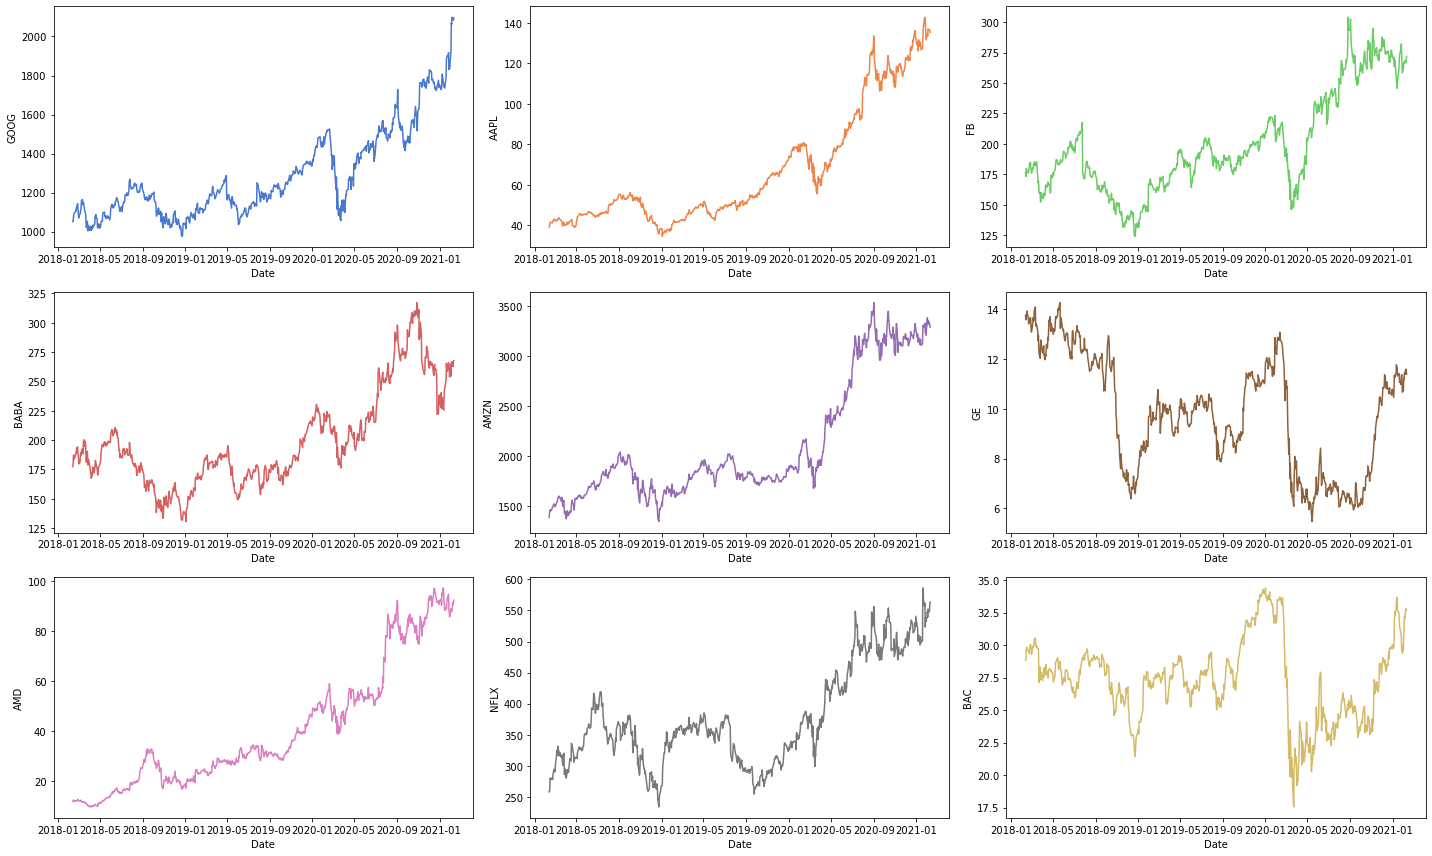

In [4]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(20, 12)
for i in range(int(len(stocks)/2)):
    sns.lineplot(data=data.iloc[:, i].dropna(),
                 ax=axs[i//3, i % 3],
                 color=standard_palette[i])

plt.tight_layout() 

In [5]:
returns = (np.log(data)).diff(30)

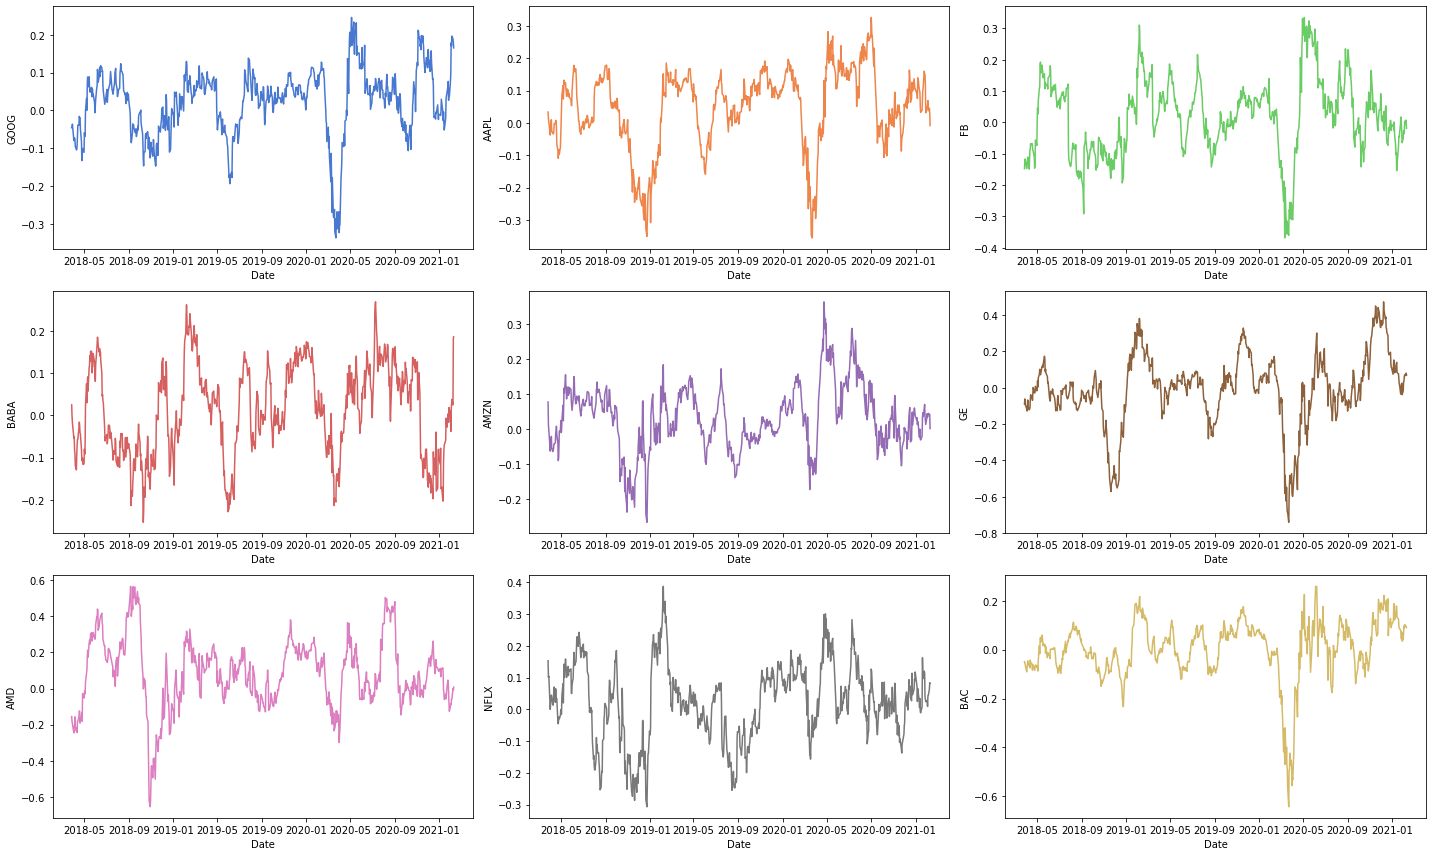

In [6]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(20, 12)
for i in range(int(len(stocks)/2)):
    sns.lineplot(data=returns.iloc[:, i].dropna(),
                 ax=axs[i//3, i % 3],
                 color=standard_palette[i])

plt.tight_layout() 

In [7]:
ex_returns = returns.mean()
cov_returns = returns.cov()

## Model foundations

#### Goal:

#### $\mathbf{w} \;=\; \begin{bmatrix}  w_1\\ \vdots\\ w_n \end{bmatrix}$

#### Ingredients:

#### $\boldsymbol{\mu} \;=\; \begin{bmatrix} \mu_1\\ \vdots \\ \mu_1 \end{bmatrix} \quad,\quad \boldsymbol{\Sigma} \;=\; \begin{bmatrix} \sigma_{11} & \dots & \sigma_{n1}\\ \vdots & \ddots & \vdots\\ \sigma_{1n} & \dots & \sigma_{nn} \end{bmatrix}$

#### Plan of Attack:
1. Define our objective function
2. OPTIMIZE!
3. Analyze solutions

In [8]:
# Defining weights vector
n = len(stocks)
w = cp.Variable(n)

## Feasible set of portfolios... convex hull?

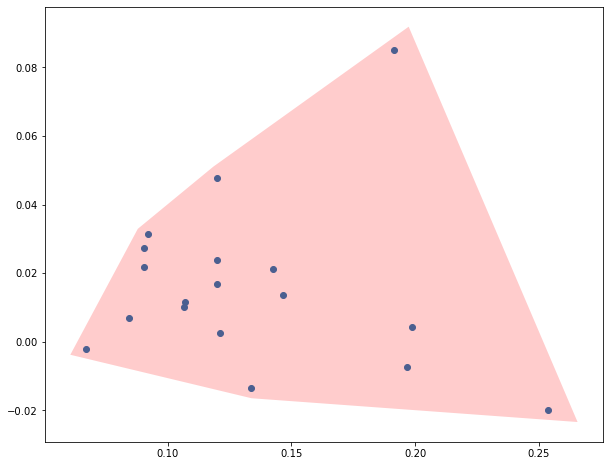

In [9]:
stock_return_vol = returns.std()
singleton_portfolios = {'Volatility': stock_return_vol, 'Returns': ex_returns}

points = (pd.DataFrame(data=singleton_portfolios)).to_numpy()
hull = ConvexHull(points)

f, axs = plt.subplots(figsize=(10, 8))
plt.scatter(x=points[:, 0], y=points[:, 1])

cent = np.mean(points, 0)
pts = []
for pt in points[hull.simplices]:
    pts.append(pt[0].tolist())
    pts.append(pt[1].tolist())

pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                  p[0] - cent[0]))
pts = pts[0::2]  # Deleting duplicates
pts.insert(len(pts), pts[0])
k = 1.1
color = 'red'
poly = Polygon(k*(np.array(pts) - cent) + cent,
               facecolor=color, alpha=0.2)

poly.set_capstyle('round')
plt.gca().add_patch(poly) 
plt.show()

## Plotting portfolios

In [10]:
def plot_portfolios(portfolios, funky=False):
    schemes = ['viridis', 'magma', 'hsv', 'tab20', 'gist_stern', 'terrain']
    f, axs = plt.subplots(figsize=(10, 8))
    if funky:
        plt.scatter(data=portfolios,
                    x='Volatility',
                    y='Returns',
                    cmap=choice(schemes),
                    c=np.random.randint(0, 50, portfolios.shape[0]))
        
    else:
        plt.scatter(data=portfolios,
                    x='Volatility',
                    y='Returns')
        plt.gca().add_patch(Polygon(k*(np.array(pts) - cent) + cent,
                            facecolor=color, alpha=0.2))
        
    axs.set(xlim=(0.01, 0.4))
    axs.set(ylim=(-0.04, 0.15))
    plt.show()

## Brute force approach: Monte Carlo simulation (100 samples)

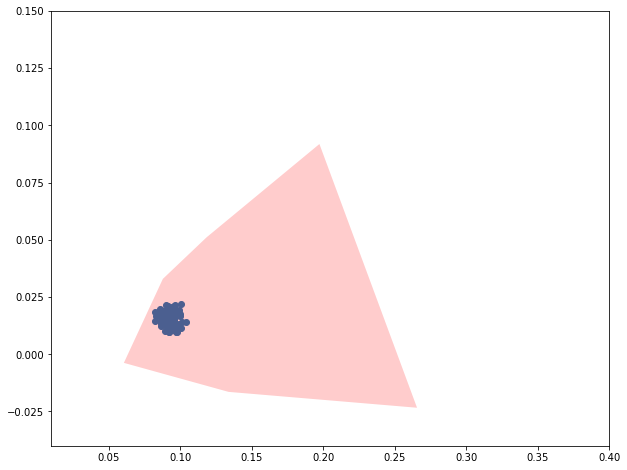

In [11]:
# Monte Carlo simultions of different portfolios
p_ret = []
p_vol = []
num_portfolios = 100

for portfolio in range(num_portfolios):
    weights = np.random.rand(n)
    weights = weights/np.sum(weights)
    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    p_ret.append(ret)
    p_vol.append(vol)

    
long_simulated_portfolios = pd.DataFrame({'Returns': p_ret, 
                                          'Volatility': p_vol, 
                                          'Type': np.ones(num_portfolios)})

plot_portfolios(long_simulated_portfolios)

## Monte Carlo simulation (1,000 samples)

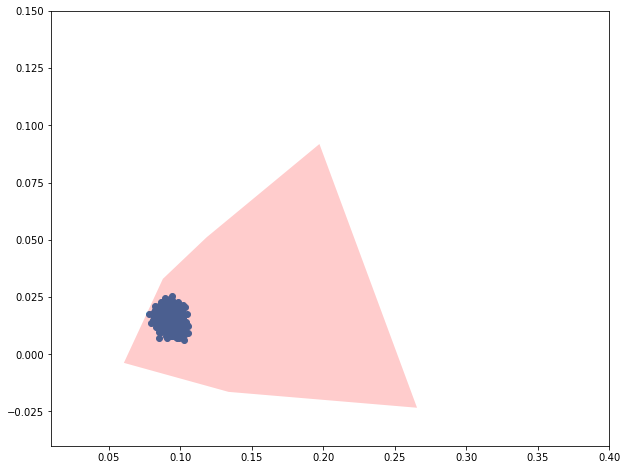

In [12]:
# Monte Carlo simultions of different portfolios
p_ret = []
p_vol = []
num_portfolios = 1000

for portfolio in range(num_portfolios):
    weights = np.random.rand(n)
    weights = weights/np.sum(weights)

    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    p_ret.append(ret)
    p_vol.append(vol)

long_simulated_portfolios = pd.DataFrame({'Returns': p_ret,
                                          'Volatility': p_vol, 
                                          'Type': np.ones(num_portfolios)})

plot_portfolios(long_simulated_portfolios)

## Monte Carlo simulation (500,000 samples)

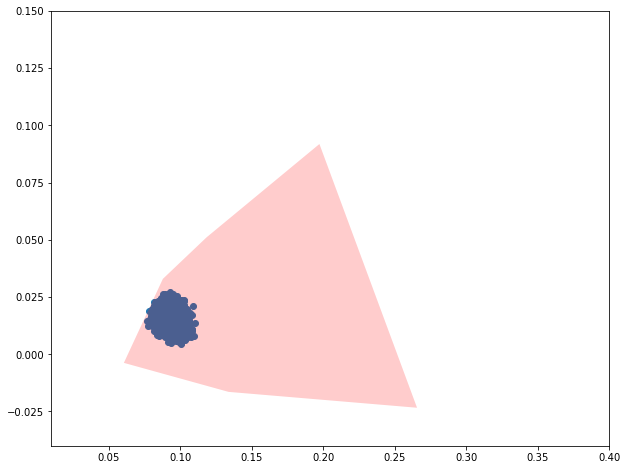

In [13]:
# Monte Carlo simultions of different portfolios
p_ret = []
p_vol = []
num_portfolios = 10000

for portfolio in range(num_portfolios):
    weights = np.random.rand(n)
    weights = weights/np.sum(weights)
    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    p_ret.append(ret)
    p_vol.append(vol)

simulations = {'Returns': p_ret, 'Volatility': p_vol,
               'Type': np.ones(num_portfolios)}
long_simulated_portfolios = pd.DataFrame(simulations)

plot_portfolios(long_simulated_portfolios)

## Monte Carlo simulation (10,000 samples - NOW WITH SHORTING!)

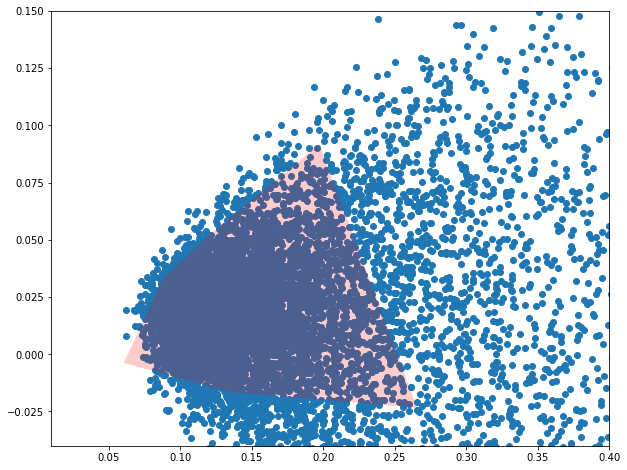

In [14]:
# Monte Carlo simultions of different portfolios
p_ret = []
p_vol = []
num_portfolios = 10000

for portfolio in range(num_portfolios):
    weights = 2*np.random.rand(n) - 1
    weights = weights/np.sum(weights)
    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    p_ret.append(ret)
    p_vol.append(vol)
    
simulated_portfolios = pd.DataFrame({'Returns': p_ret, 
                                     'Volatility': p_vol, 
                                     'Type': np.ones(num_portfolios)})

plot_portfolios(simulated_portfolios)

## Model 1: Minimum volatility (long-only)

#### $\underset{\mathbf{w}}{\text{min}} \quad  \mathbf{w}^T\:\boldsymbol{\Sigma}\: \mathbf{w}$
#### $\textrm{s.t}\quad \mathbf{w}^T \mathbf{1}=1 \quad , \quad w_i\geq 0$


In [15]:
# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [w >= 0,
               (np.ones(n))@w == 1]

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)


The optimal value is 0.002796584237654568
Solution weight is
[-4.41685694e-22  2.91604579e-23 -8.94951075e-24  1.41650636e-01
  7.97610834e-02 -3.85464682e-21  1.41532425e-21  4.86772966e-02
 -1.47984859e-21 -1.88970748e-21  4.90739647e-01 -3.78413532e-22
 -1.19878658e-21  4.44132932e-21  8.03911808e-22 -8.52782176e-22
  2.39171336e-01 -1.45064996e-21]


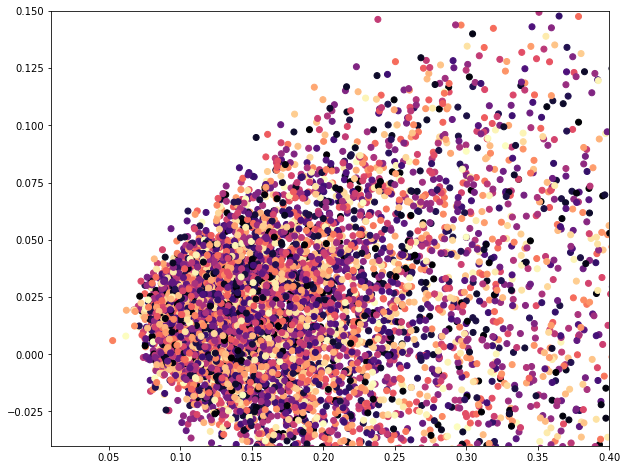

In [16]:
weights = w.value
ret = (ex_returns.to_numpy())@weights
vol = (weights@cov_returns@weights)**0.5

simulated_portfolios = simulated_portfolios.append({'Returns': ret,
                                                    'Volatility': vol,
                                                    'Type': 'Minimum Volatility'}, ignore_index=True)

long_simulated_portfolios = long_simulated_portfolios.append({'Returns': ret,
                                                              'Volatility': vol,
                                                              'Type': 'Minimum Volatility'}, ignore_index=True)
plot_portfolios(simulated_portfolios, funky=True)

## Model 2: Minimum volatility

#### $\underset{\mathbf{w}}{\text{min}} \quad  \mathbf{w}^T\:\boldsymbol{\Sigma}\: \mathbf{w}$
#### $\textrm{s.t}\quad \mathbf{w}^T \mathbf{1}=1 \quad$


In [17]:
# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [(np.ones(n))@w == 1]

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)


The optimal value is 0.0012304522269188552
Solution weight is
[-0.06136281 -0.00301796 -0.07141762  0.22144712  0.14710397 -0.02910166
 -0.11725758  0.15064986 -0.45359502  0.07729424  0.43004775 -0.10065662
 -0.06194044  0.0051744  -0.14114809  0.11639206  0.36084148  0.53054692]


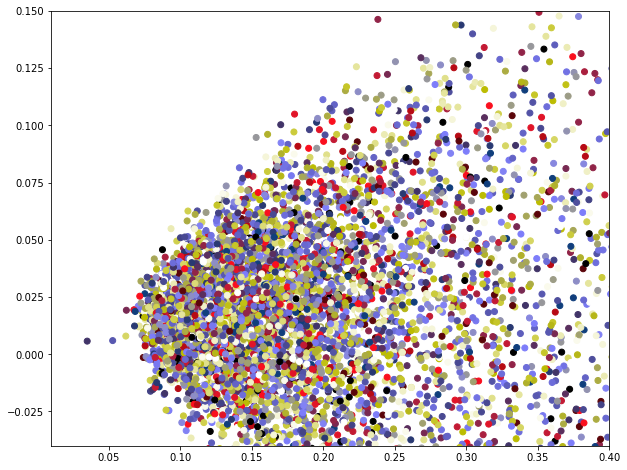

In [18]:
weights = w.value
ret = (ex_returns.to_numpy())@weights
vol = (weights@cov_returns@weights)**0.5
simulated_portfolios = simulated_portfolios.append({'Returns': ret,
                                                    'Volatility': vol,
                                                    'Type': 'Minimum Volatility (with shorting)'}, ignore_index=True)
plot_portfolios(simulated_portfolios, funky=True)

## Model 3: Risk-efficient

#### $\underset{\mathbf{w}}{\text{min}} \quad  \mathbf{w}^T\:\boldsymbol{\Sigma} \: \mathbf{w}$
#### $\textrm{s.t}\quad \boldsymbol{\mu}^T\!\mathbf{w} \geq \mu^* \quad , \quad \mathbf{w}^T \mathbf{1}=1$

In [19]:
# Defining target return rate in (0,0.25]
mu = (random())/4

# Creating objective function and constraints
objective = cp.quad_form(w, cov_returns)
constraints = [(ex_returns.to_numpy())@w >= mu,      # target return constraint
               (np.ones(n))@w == 1]     # market-neutral constraint

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

# Print result
print('Target return rate: ', mu)
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)

Target return rate:  0.21185843423430817

The optimal value is 0.044128562372724195
Solution weight is
[ 0.76682382  1.63747979 -0.53877033 -0.6596642  -0.54552819 -0.68675009
  0.31943458  1.10427738 -2.53190831  0.94035643 -1.90443072 -0.19616817
 -1.003815   -0.35123675 -0.53231744  1.30453325  0.43930216  3.43838179]


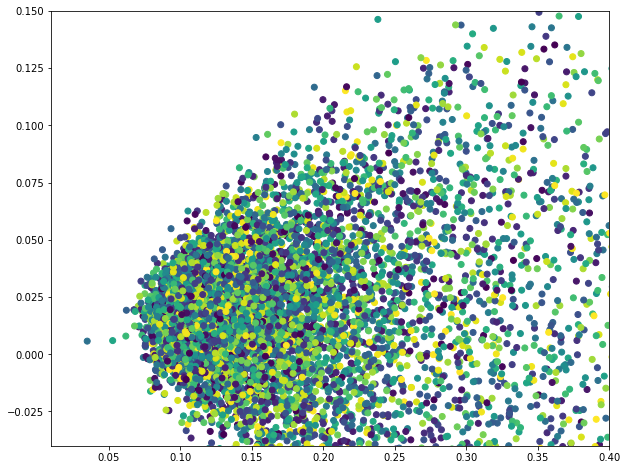

In [20]:
weights = w.value
ret = (ex_returns.to_numpy())@weights
vol = (weights@cov_returns@weights)**0.5
simulated_portfolios = simulated_portfolios.append({'Returns': ret,
                                                    'Volatility': vol,
                                                    'Type': 'Risk-efficient'}, ignore_index=True)
plot_portfolios(simulated_portfolios, funky=True)

## Model 4: Return-efficient

#### $\underset{\mathbf{w}}{\text{max}} \quad \boldsymbol{\mu}^T\!\mathbf{w}$
#### $\textrm{s.t}\quad \mathbf{w}^T\:\boldsymbol{\Sigma} \: \mathbf{w} \leq \sigma^{2*} \quad , \quad \mathbf{w}^T \mathbf{1}=1$

In [21]:
# Defining target volatility in [0,0.1)
sigma = 0.07

# Creating objective function and constraints
objective = (ex_returns.to_numpy())@w
constraints = [cp.quad_form(w, cov_returns) <= sigma**2,
               (np.ones(n))@w == 1]

# Solving for optimal portfolio
problem = cp.Problem(cp.Maximize(objective), constraints)
problem.solve()

# Print result
print('target volatility: ', sigma)
print("\nThe optimal value is", problem.value)
print("Solution weight is")
print(w.value)

target volatility:  0.07

The optimal value is 0.06601836124661604
Solution weight is
[ 0.18086039  0.47678496 -0.2081062  -0.03625502 -0.05547289 -0.2214467
  0.01046346  0.42956107 -1.06144703  0.32971743 -0.25272646 -0.12859121
 -0.33741425 -0.09906659 -0.25555497  0.46389247  0.38378922  1.38101233]


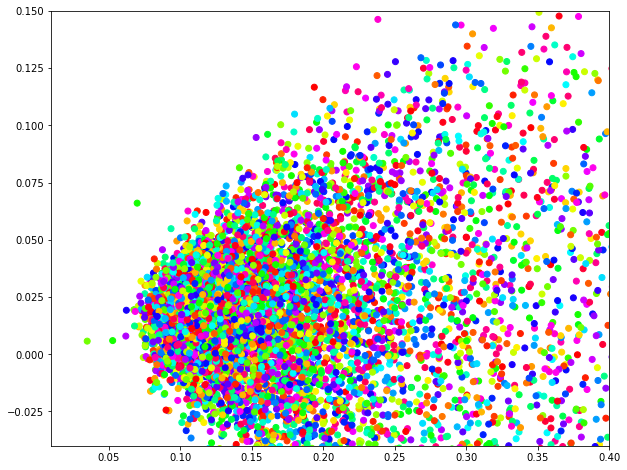

In [22]:
weights = w.value
ret = (ex_returns.to_numpy())@weights
vol = (weights@cov_returns@weights)**0.5
simulated_portfolios = simulated_portfolios.append({'Returns': ret,
                                                    'Volatility': vol,
                                                    'Type': 'Return-efficient'}, ignore_index=True)
plot_portfolios(simulated_portfolios, funky=True)

## Putting it all together - duality, quadratic risk utility,and the efficient frontier

#### $\underset{\mathbf{w}}{\text{min}} \quad \mathbf{w}^T\:\boldsymbol{\Sigma} \: \mathbf{w} \; - \; \lambda \boldsymbol{\mu}^T\!\mathbf{w}$
#### $\textrm{s.t} \quad \mathbf{w}^T \mathbf{1}=1$


#### Here, $\lambda$ is the risk aversion parameter


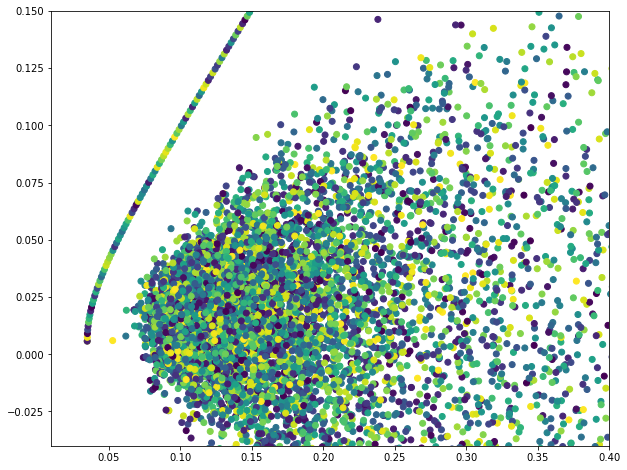

In [23]:
# Creating lambda sample
lmda = cp.Parameter(nonneg=True)
LMDA_SPACE = np.linspace(0, 20, num=6000)

# Declaring problem
objective = cp.quad_form(w, cov_returns)-lmda*((ex_returns.to_numpy())@w)
constraints = [(np.ones(n))@w == 1]

problem = cp.Problem(cp.Minimize(objective), constraints)

efficient_frontier = simulated_portfolios

# Solving problem for different lambda parameters
for l in LMDA_SPACE:
    lmda.value = l
    problem.solve()
    weights = w.value
    ret = (ex_returns.to_numpy())@weights
    vol = (weights@cov_returns@weights)**0.5
    efficient_frontier = efficient_frontier.append({'Returns': ret,
                                                    'Volatility': vol,
                                                    'Type': 'Efficient Frontier'}, ignore_index=True)

plot_portfolios(efficient_frontier, funky=True)

## Model 5: Maximum Sharpe Ratio
#### $\underset{\mathbf{w}}{\text{max}} \frac{\boldsymbol{\mu}^T\!\mathbf{w} - r_f}{\sqrt{\mathbf{w}^T\:\boldsymbol{\Sigma} \: \mathbf{w}}}$
#### $\textrm{s.t}\quad \mathbf{w}^T \mathbf{1}=1$

#### **STOP!!! THIS IS NOT A CONVEX PROBLEM**

Assume there exsists $\mathbf{w}$ such that $\; \boldsymbol{\mu}^T\!\mathbf{w} \; -  \; r_f \geq 0 \quad$  (this is not unreasonable).
Then solve the following problem and derive optimal portfolio weights with the corresponding variable substitution:

#### $\underset{\mathbf{y},\kappa}{\text{min}} \quad  \mathbf{y}^T\:\boldsymbol{\Sigma} \: \mathbf{y}$
#### $\textrm{s.t}\quad (\boldsymbol{\mu} - r_f\mathbf{1})^T\mathbf{y} = 1 \quad , \quad  \mathbf{y}^T \mathbf{1}=\kappa \quad \implies w^*=\frac{\mathbf{y}^*}{\kappa^*}$

In [24]:
# Set risk-free rate (monthly)
r = 0.002083

# Creating objective function and constraints
k = cp.Variable()
objective = cp.quad_form(w, cov_returns)
constraints = [(ex_returns.to_numpy() - r)@w == 1,
               (np.ones(n))@w == k,
               k >= 0]

# Solving for optimal portfolio
problem = cp.Problem(cp.Minimize(objective), constraints)
problem.solve()

max_sharpe = ((ex_returns.to_numpy())@w.value - r) / \
    ((w.value@cov_returns@w.value)**0.5)
# Print result
print('Optimal kappa: ', k.value)
print('Optimal Sharpe: ', max_sharpe)
print("Solution weight is")
print((w.value / k.value))

Optimal kappa:  2.961541377757958
Optimal Sharpe:  1.0047208179006593
Solution weight is
[ 1.28065295  2.65528845 -0.82872844 -1.20632922 -0.97525571 -1.09477276
  0.59037007  1.6959334  -3.82134944  1.47582329 -3.35280358 -0.25542608
 -1.58817916 -0.57236376 -0.77500937  2.0416878   0.48798127  5.24248028]


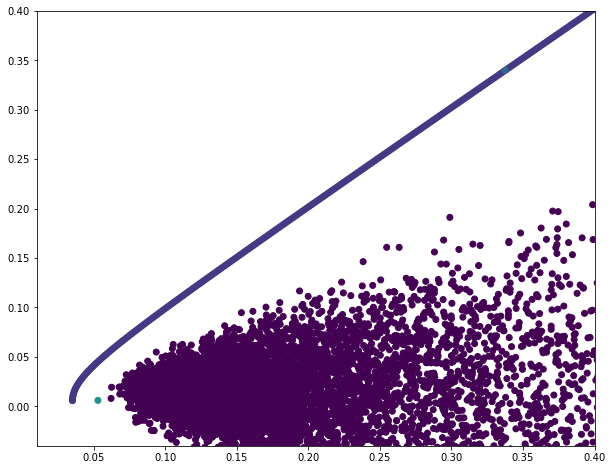

In [25]:
weights = (w.value / k.value).round(16) + 0.0
ret = (ex_returns.to_numpy())@weights
vol = (weights@cov_returns@weights)**0.5
efficient_frontier = efficient_frontier.append({'Returns': ret,
                                                'Volatility': vol,
                                                'Type': 'Max Sharpe Ratio'}, ignore_index=True)
f, axs = plt.subplots(figsize=(10, 8))
plt.scatter(data=efficient_frontier,
            x='Volatility',
            y='Returns',
            c=efficient_frontier['Type'].astype('category').cat.codes)

axs.set(xlim=(0.01, 0.4))
axs.set(ylim=(-0.04, 0.4))

plt.show()

## Lessons to be learned:
#### 1. Correlation matters
#### 2. Pick in the frontier
#### 3. Know your limits

## References

- **Cornuejols, G. and Tutuncu, R.** (2006). *Optimization Methods in Finance*. [URL Link.](http://web.math.ku.dk/~rolf/CT_FinOpt.pdf)

- **Dhaliwal, A. and Vyas, A.** (2020). Portfolio Optimisation with PortfolioLab: Mean-Variance Optimisation. Hudson and Thames. [URL Link.](https://hudsonthames.org/portfolio-optimisation-with-portfoliolab-mean-variance-optimisation/)

- **Kempthorne, P.** (2013). Portfolio Theory. *Topics in Mathematics with Applications in Finance - Lecture 14*. MIT OpenCourseWare. [URL Link.](https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/lecture-notes/MIT18_S096F13_lecnote14.pdf)

- **Schmelzer, T. and Hauser, R.** (2013). Seven Sins In Portfolio Optimization. [URL Link.](https://arxiv.org/pdf/1310.3396.pdf)